In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import json
import matplotlib.pyplot as plt

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('training_data.csv')
df['YearMonth'] = pd.to_datetime(df['YearMonth'])

In [3]:
# Process all zipcodes
results = []
evaluation_metrics = []

In [4]:
for zipcode in df['zipcode'].unique():
    zipcode_data = df[df['zipcode'] == zipcode].sort_values('YearMonth')
    if len(zipcode_data) < 24:  
        continue
    
    prophet_df = zipcode_data[['YearMonth', 'AveragePrice']].rename(columns={'YearMonth': 'ds', 'AveragePrice': 'y'})
    
    # Fit Prophet model
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_df)
    
    future = model.make_future_dataframe(periods=60, freq='ME')
    forecast = model.predict(future)
    
    current_price = prophet_df['y'].iloc[-1]
    
    roi_results = {}
    for year in [1, 3, 5]:
        future_price = forecast['yhat'].iloc[12*year - 1]
        roi = (future_price - current_price) / current_price
        roi_lower = (forecast['yhat_lower'].iloc[12*year - 1] - current_price) / current_price
        roi_upper = (forecast['yhat_upper'].iloc[12*year - 1] - current_price) / current_price
        roi_results[f'{year}Yr_ROI'] = roi
        roi_results[f'{year}Yr_ROI_Lower'] = roi_lower
        roi_results[f'{year}Yr_ROI_Upper'] = roi_upper
    
    # evaluation metrics 
    historical_forecast = forecast[:len(prophet_df)]
    mae = mean_absolute_error(prophet_df['y'], historical_forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(prophet_df['y'], historical_forecast['yhat']))
    r2 = r2_score(prophet_df['y'], historical_forecast['yhat'])
    mape = np.mean(np.abs((prophet_df['y'] - historical_forecast['yhat']) / prophet_df['y'])) * 100
    
    evaluation_metrics.append({
        'zipcode': int(zipcode),
        'MAE': float(mae),
        'RMSE': float(rmse),
        'R²': float(r2),
        'MAPE': float(mape)
    })

    results.append({
        'zipcode': int(zipcode),
        'borough': zipcode_data['Borough'].iloc[0],
        'current_price': float(current_price),
        **{key: float(value) for key, value in roi_results.items()}
    })

12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing
12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:36 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1]

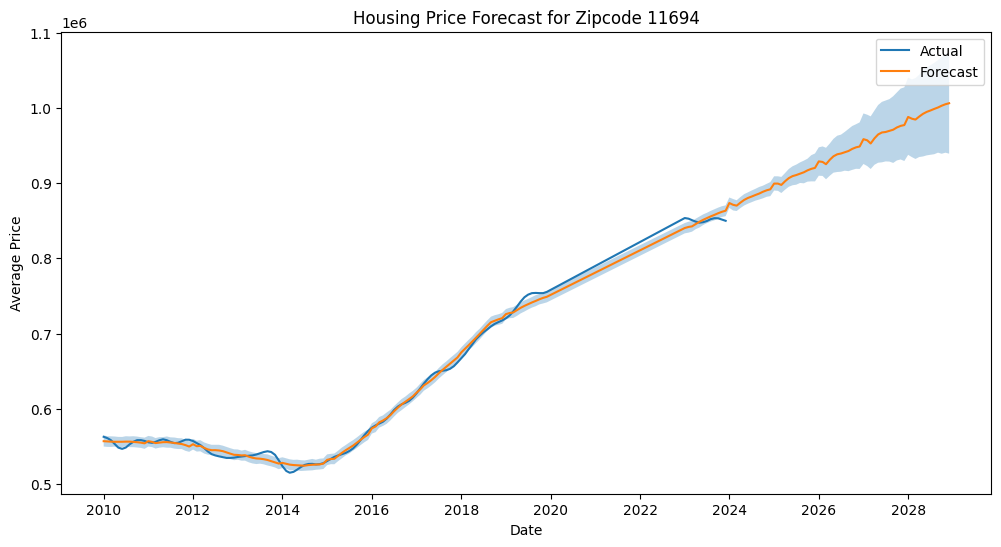

In [5]:
# Plot forecast for each zipcode
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.title(f'Housing Price Forecast for Zipcode {zipcode}')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [6]:
with open('zipcode_scores_prophet.json', 'w') as f:
    json.dump(results, f, indent=4)

In [7]:
# Analysis of results
results_df = pd.DataFrame(results)
evaluation_df = pd.DataFrame(evaluation_metrics)

print("Summary statistics of evaluation metrics:")
print(evaluation_df[['MAE', 'RMSE', 'R²', 'MAPE']].describe())

print("\nTop 5 zipcodes by 5-year ROI:")
top_5_roi = results_df.sort_values('5Yr_ROI', ascending=False).head()
top_5_roi_with_metrics = top_5_roi.merge(evaluation_df, on='zipcode')
print(top_5_roi_with_metrics[['zipcode', 'borough', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI', 'R²']])

print("\nBottom 5 zipcodes by 5-year ROI:")
bottom_5_roi = results_df.sort_values('5Yr_ROI').head()
bottom_5_roi_with_metrics = bottom_5_roi.merge(evaluation_df, on='zipcode')
print(bottom_5_roi_with_metrics[['zipcode', 'borough', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI', 'R²']])

Summary statistics of evaluation metrics:
                MAE          RMSE          R²      MAPE
count    165.000000    165.000000  165.000000  1.000000
mean    7380.484662  10055.833950    0.983662  1.353102
std     7545.688080   9856.286508    0.076701       NaN
min       12.614609     28.094000    0.271024  1.353102
25%     3427.287242   4629.586876    0.988753  1.353102
50%     4636.178845   6503.460794    0.996103  1.353102
75%     8010.620391  12015.399789    0.998378  1.353102
max    48172.131211  60175.253242    0.999851  1.353102

Top 5 zipcodes by 5-year ROI:
   zipcode    borough  current_price   1Yr_ROI   3Yr_ROI   5Yr_ROI        R²
0    10035  Manhattan       610090.0  0.067943  0.180699  0.446371  0.996683
1    10001  Manhattan      1686004.0 -0.068992  0.081479  0.419395  0.993359
2    10014  Manhattan      1653163.0 -0.064914  0.077124  0.367827  0.990572
3    10005  Manhattan      1081355.0  0.076373  0.132995  0.317150  0.992860
4    10018  Manhattan      1313530.0 -

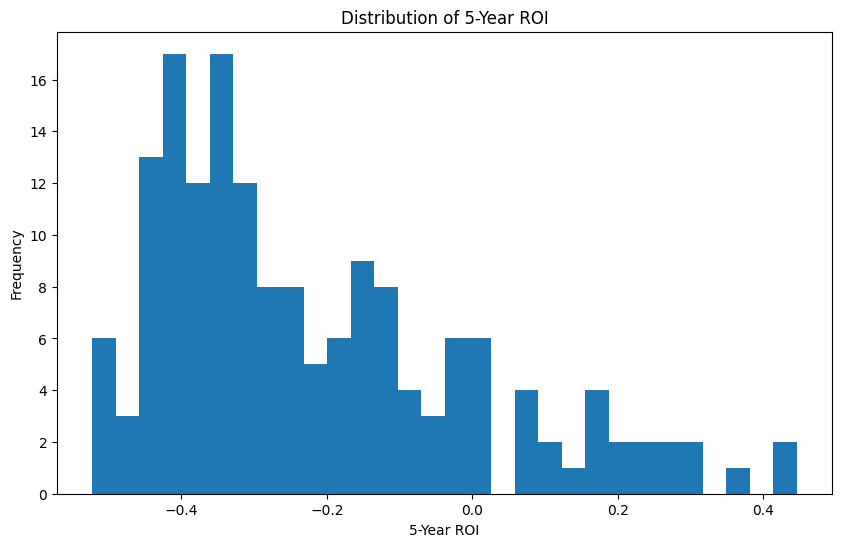

In [8]:
# Plot distribution of 5-year ROI
plt.figure(figsize=(10, 6))
plt.hist(results_df['5Yr_ROI'], bins=30)
plt.title('Distribution of 5-Year ROI')
plt.xlabel('5-Year ROI')
plt.ylabel('Frequency')
plt.show()

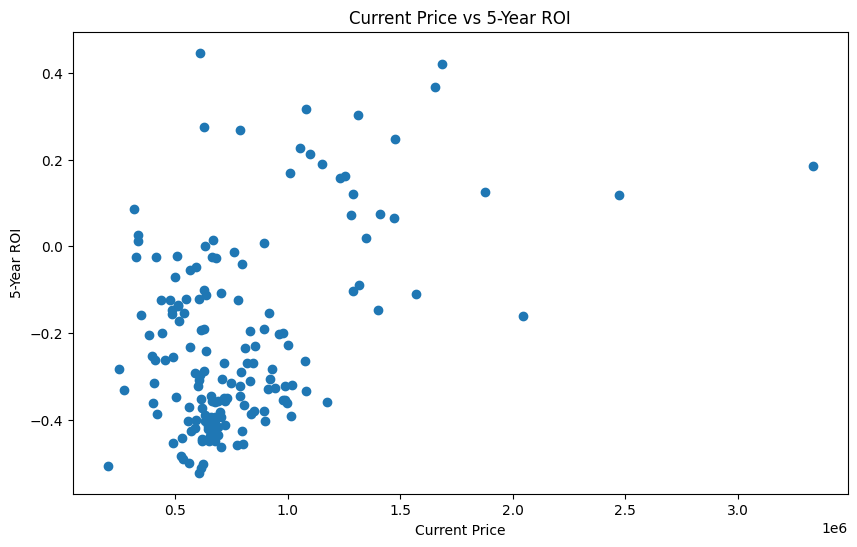

In [9]:
# Scatter plot of current price vs 5-year ROI
plt.figure(figsize=(10, 6))
plt.scatter(results_df['current_price'], results_df['5Yr_ROI'])
plt.title('Current Price vs 5-Year ROI')
plt.xlabel('Current Price')
plt.ylabel('5-Year ROI')
plt.show()